# Using FIES data to calculate food insecurity prevalence rates

This notebook presents the validation of Food Insecurity Experience Scale (FIES) data using the Rasch model and to calculate an estimate of the prevalence of food insecurity in the population.

## FIES analysis methodology (Rasch Model)
Item Response Theory (IRT) is a methodology used to analyse responses to survey or test questions.
The Rasch model is one of several models in IRT and is applied for the analysis of FIES data. Item response theory aims to improve the measurement accuracy and reliability of surveys and tests through analysis of response data. The item response theory (IRT) measurement model known as the `Rasch` model provides a theoretical base and a set of statistical tools to:

* assess the suitability of a set of survey items for scale construction
* create a scale from the items, and compare performance of a scale in various populations and survey contexts.

The Rasch model is expressed mathematically as :


$$Prob(x_{h,i} = 1|θ_h, β_i) =  \frac {e^{θ_h - β_i}}{1 + e^{θ_h - β_i}}$$

_where $x_{ℎ,𝑖}$ is the response given by respondent *h* to item *i*, coded as 1 for “yes” and 0 for “no”.
The relative severity associated with each of the experiences (the parameters $β_i$
in the formula above) can be inferred from the frequency with which they are reported by a large sample of respondents,  assuming that, all else being equal, more severe experiences are reported by fewer respondents. 
Once the severity of each experience is estimated, the severity of a respondent’s condition (the 𝜃ℎ parameter) can be computed by noting how many of the items have been affirmed._

### Assumptions of the Rasch model
The Rasch model is based upon four key assumptions:
* Only one dimension is represented by the response data. For the FIES, this is the access dimension
of food security
* An individual’s responses to the eight FIES items are correlated with each other only because they are all conditioned by the severity of food insecurity of that individual.
* The greater the severity of food insecurity experienced by a respondent, the higher the likelihood that he or she will respond affirmatively to each item
* All items are equally strongly related to the latent trait of food insecurity and differ only in severity. ie All items discriminate equally


### Import Libraries and Load the data

In [1]:
import rpy2
import pandas as pd
import numpy as np

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

%load_ext rpy2.ipython

utils = importr('utils')
# utils.install_packages('anthro')
# utils.install_packages('RM.weights')
pandas2ri.activate()

In [3]:
%%R
library(tidyverse)
library(TAM)
library(WrightMap)
if(!require('RM.weights')) {
  install.packages('RM.weights')
  library('RM.weights')
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Loading required package: CDM
Loading required package: mvtnorm
**********************************
** CDM 8.2-6 (2022-08-25 15:43:23)       
** Cognitive Diagnostic Models  **
**********************************

* TAM 4.1-4 (2022-08-28 16:03:54)
Loading required package: RM.weights
Loading required package: psychotools
Loading required package: Hmisc

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



### Preparing the data for analysis

Based on standard procedure following the FIES data analysis methodology, extreme raw scores (0 and 8) will be excluded to avoid potential bias resulting from large proportions of these raw scores. For more information checkout the VOH document [page 11-12 ](http://www.fao.org/3/a-i4830e.pdf)

In [6]:
# Data Preparation for VOH app
df = pd.read_csv("../data/fao_round6_ng_clean_data.csv")
print("Before removing extreme values", df.shape)

# Drop extreme values of 0 and 8 as standard procedure
# df = df[~df.fies_rawscore.isin([0,8.0])].reset_index(drop=True)
print("After removing extreme values", df.shape)
fies_cols = [col for col in df.columns if col.startswith("fies_")]

fies_rasch = df[fies_cols].drop(columns="fies_rawscore").rename(columns={
    "fies_worried": "Worried",
    "fies_healthy": "Healthy",
    "fies_fewfoods": "Fewfood",
    "fies_skipped": "Skipped",
    "fies_ateless": "Ateless",
    "fies_ranout": "Runout",
    "fies_hungry": "Hungry",
    "fies_whlday": "Whlday" 
}).astype(int)

fies_rasch = pd.concat([fies_rasch, df[["weight_final"]]], axis=1)
fies_rasch = fies_rasch.rename(columns={"weight_final": "wt"})
fies_rasch["wt.person"] = np.nan
fies_rasch["Urban"] = 1
fies_rasch["Region"] = df["state"]



# 
fies_rasch.to_csv("../data/fies_rasch.csv", index=False)
fies_rasch.head()

Before removing extreme values (3438, 158)
After removing extreme values (3438, 158)


,Worried,Healthy,Fewfood,Skipped,Ateless,Runout,Hungry,Whlday,wt,wt.person,Urban,Region
0,1,1,1,1,1,1,1,1,0.198500,NaN,1,Zamfara
1,1,1,1,1,1,1,1,1,0.187787,NaN,1,Zamfara
2,1,1,1,1,1,1,1,1,0.187787,NaN,1,Zamfara
3,1,1,1,1,1,1,1,1,0.198500,NaN,1,Zamfara
4,1,1,1,1,1,1,1,0,0.198500,NaN,1,Zamfara


In [7]:
%%R

# Define the data file path
file_path <- "../data/fao_round6_ng_clean_data.csv"

# Read the CSV file while selecting columns using the regex pattern
fies.ng <- read_csv(file_path)

fies.ng <- fies.ng %>%
  select(matches("^(weight|fies)"))

# Convert the values to integers
# df <- as.data.frame(lapply(df, as.integer))

# # Drop values with extreme scores 
# fies.ng <- subset(fies.ng, !(fies_rawscore %in% c(0.0, 8.0)))

# dim(df)
# head(fies.ng)
# write.csv(fies.ng, "../data/fies_rasch_analysis.csv", row.names = FALSE)
dim(fies.ng)

Rows: 3438 Columns: 158
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (19): country, state, local_govt_area, hh_agricactivity, hh_gender, hh_...
dbl (139): hh_size, hh_maritalstat, weight_final, income_main, income_main_c...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 3438   10


## FIES data analysis

We used the Voices of the Hungry project’s FIES app (a free and simple analytical tool for analyzing FIES data) and Voices of the Hungry (VOH) project provides a free analytical tool `RM.weight` ([RM.weight](https://cran.r-project.org/web/packages/RM.weights/index.html)) to facilitate the Rasch analysis of FIES and produce the respondent and item parameter estimates. To facilitate the **equating** process to produce comparable estimates of the prevalence of food insecurity, we use the [Excel template](https://www.fao.org/fileadmin/user_upload/voices_of_the_hungry/docs/EPE_Example_05.xlsx) provided by the FAO.

The package (RM.weight) produces estimates of item severity parameters by maximizing the likelihood function conditional on the raw score, and using, in the estimating process, only cases with non-extreme response patterns (that is, with raw score between 1 and 7).




The analysis of FIES data involves:

1. **Parameter estimation**: To calculate the level of food insecurity severity associated with each
question and each respondent
2. **Statistical validation**:  To assess whether, depending on the quality of the data collected, the
measure is valid, (i.e. the data are consistent with the theoretical assumptions that inform the
model).
3. **Calculation of food insecurity prevalence estimates**: To calculate a measure of severity of the
food insecurity condition experienced by each respondent, based on their answers to the eight FIES
questions. This is then used to estimate the prevalence of food insecurity at moderate and/or severe levels in the population.

Asides `RM.weight`, we shall estimate the item and respondent parameters with Voices of the Hungry Project FIES [app](https://fies.shinyapps.io/ExtendedApp/).

### 1. Parameter Estimation

In [8]:
%%R
# Questionare data and weights
xx.nigeria <- fies.ng[, 2:9]
wt.nigeria <- fies.ng$weight_final

# # Fit weight Rasch model
rr.nigeria <- RM.w(xx.nigeria, wt.nigeria)

# # Fit unweighted Rasch
rr.nigeria.nw <- RM.w(xx.nigeria)

dim(fies.ng)
head(xx.nigeria)

# A tibble: 6 × 8
  fies_worried fies_healthy fies_fewfoods fies_skipped fies_ateless fies_ranout
         <dbl>        <dbl>         <dbl>        <dbl>        <dbl>       <dbl>
1            1            1             1            1            1           1
2            1            1             1            1            1           1
3            1            1             1            1            1           1
4            1            1             1            1            1           1
5            1            1             1            1            1           1
6            1            1             1            1            1           1
# ℹ 2 more variables: fies_hungry <dbl>, fies_whlday <dbl>


#### **Item Parameters**

The **item parameter** is estimated based on the overall **pattern of responses** given by all
respondents. 

A question representing a **less severe experience will have a smaller parameter** value,
whereas a question representing a **more severe** experience will have a **larger parameter** value.
The **relative severity** of the items is determined based upon the understanding that the **more severe** an item is, the **less likely** respondents are to report it. 



In [32]:
%%R
parameter_estimate <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.nigeria$b,       # Item severity estimate
    "Stardard Error" = rr.nigeria$se.b,   # Item standard error
    "Infit" = rr.nigeria$infit,            # Infit
    "Std error Infit" = rr.nigeria$se.infit,     # standard error infit
    "Outfit" = rr.nigeria$outfit
  ),
  var = "Item"
)

write.csv(parameter_estimate, "../data/fies_item_statistics.csv")

print(parameter_estimate)



           Item Item.Severity Stardard.Error     Infit Std.error.Infit
1  fies_worried     -1.633130     0.08154181 0.8748814      0.04899975
2  fies_healthy     -2.510971     0.09719270 1.3889476      0.06002653
3 fies_fewfoods     -2.087817     0.08887238 0.9467257      0.05436077
4  fies_skipped     -1.008472     0.07371808 0.7738081      0.04401447
5  fies_ateless     -1.825444     0.08446555 0.8663274      0.05115488
6   fies_ranout      2.556939     0.06123121 1.0570466      0.03530361
7   fies_hungry      1.715666     0.05879363 0.9799068      0.03457424
8   fies_whlday      4.793094     0.10166417 0.9800179      0.08173899
     Outfit
1 1.2618637
2 3.1040358
3 2.4688484
4 0.6908875
5 1.4249302
6 1.2119176
7 1.2001174
8 3.4847764



<center>
<img src="../assets/item_statistic.png" width="500" />
<figcaption style="font-size: 10px; font-style: italic;">Fig. 1: Estimated Item parameter  and errors using the Rasch model; created using the Voices of the Hungry project’s FIES app(https://fies.shinyapps.io/ExtendedApp/)</figcaption>
</center>


* `N_Yes_Compl`: refers to the number of affirmative response to this item among those whom have answered either YES or NO to each of the eight items.

**Observations**

**The higher the severity of an item, the more severe the experience is**. The item `fies_whlday` (eating anything for a whole day because of a lack of money or other resources) has the highest item severity, representing therefore the most severe experience 

* There was a range of −2.51 to 4.79 (7.3 logits) in FIES item severity parameters
* The item `fies_whlday` has the highest parameter (4.79 logits) with the lowest affirmative response (21%), whereas the item `fies_healthy` had the lowest parameter (−2.51) and was more likely to obtain an affirmative response (92.2%).
* `fies_whlday` has the highest severity, meaning, of all the items, it received the fewest number of "YES" response.

#### **Respondent/Raw score parameters**

A respondent's raw score is the basis for calculating the respondent parameter.
No matter how many respondents are included in a sample, there will always be up to nine distinct
values of respondent parameters, one for each possible raw score (0-8)

**Respondent parameters** allow us to more precisely evaluate the relative differences in food
insecurity severity along the scale, between the respondents with each raw score.

In [33]:
%%R
respondent_param_estimate <- tibble::rownames_to_column(
  data.frame(
    "Respondent Severity" = rr.nigeria$a,       # Respondent severity for each raw score
    "Stardard Error" = rr.nigeria$se.a,    # Respondent measurement error for each raw score
    "Weighted Class" = rr.nigeria$wt.rs 
  ),
  var = "Item"
)
write.csv(respondent_param_estimate, "../data/respondent_params_statistics.csv", )
respondent_param_estimate

  Item Respondent.Severity Stardard.Error Weighted.Class
1    1          -4.1100157      1.5008040      109.87656
2    2          -3.2869954      1.1355454       96.97880
3    3          -2.2684472      0.9294112       94.55714
4    4          -1.4397560      0.9122029      145.76993
5    5          -0.5323888      1.0121570      285.84382
6    6           0.6930952      1.1953997      704.84955
7    7           2.2000194      1.2496606      847.99920
8    8           3.9762050      1.4553795      560.90324
9    9           5.2347520      1.5008040      593.50025



<center>
<img src="../assets/respondent_estimate.png" width="500" />
    <figcaption style="font-size: 10px; font-style: italic;">Fig. 2: Estimated Respondent parameter  and errors using the Rasch model; created using the Voices of the Hungry project’s FIES app(https://fies.shinyapps.io/ExtendedApp/)</figcaption>
</center>


In [37]:
%%R
### Calculate raw scores (number of yes for each individual to the 8 questions)
rv.nigeria=rowSums(xx.nigeria)

## Raw score distribution
# Unweighted
table(rv.nigeria)
# Weighted
print(tab.weight(as.factor(rv.nigeria), wt.nigeria, xx.nigeria)$RS.abs.w)

# Weighted percentage distribution
print(tab.weight(as.factor(rv.nigeria), wt.nigeria, xx.nigeria)$RS.rel.w*100)

[1] 109.88  96.98  94.56 145.77 285.84 704.85 848.00 560.90 593.50
[1]  3  3  3  4  8 20 25 16 17


#### Calculate raw scores (number of yes for each household to the 8 questions)

### 2. Statistical Validation- Accessing data quality

Item and respondent parameters estimate from any dataset, does not guarantee that the data are always of acceptable quality so that they can be used to meaningfully measure food insecurity. 
The **statistical validation** process is a fundamental screening tool for assessing data
quality and for evaluating whether a given measure of food insecurity has a solid enough statistical
basis for its intended policy and research uses. 

**FIES analysis methodology**

This involves applying the Rasch Model to the FIES response data and assessing whether the data
conform to the model’s assumptions. 

If the data do conform to the assumptions, we can conclude that the data can be used to calculate a valid measure of food insecurity.

#### **Visualizing Item Fit**

Use `WrightMap` functionality to plot item fit statistics. In the fit object, `itemfit` is a dataframe containing various fit statistics. 

We’ll plot `infit` with a lowerbound of .70 (in mean-square error units) and an upper bound of 1.3

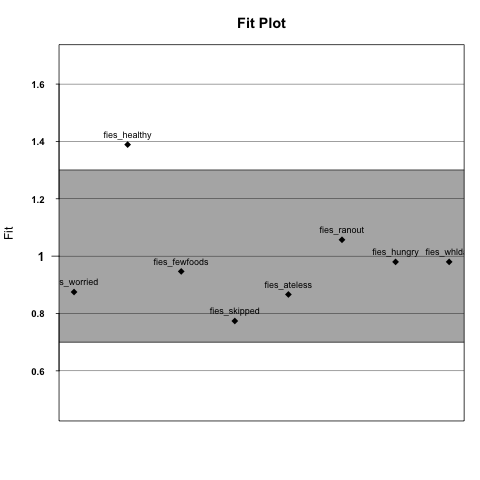

In [38]:
%%R
# Infit
infit <- rr.nigeria$infit

upper_bound <- rep(x = 1.3, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

# running fitgraph
fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

**Observation**

* No single item have a `low infit` (below 0.7). ie no redundancy.
* The assumption of equal discrimination of the eight items is assessed primarily by the item infit statistic. The expected values between 0.7 and 1.3 are considered to be reasonably consistent with the assumption of equal discrimination. All the items fall with the **adequate in fit** (0.7 to 1.3), except for `fies_healthy`.
* The infit of `fies_healthy` is **above 1.3** and can be seen to be outside the acceptable range.
* The standard error of `fies_healthy` infit statistic is 0.06. This is narrow. A wide standard error indicates a less trustworthy result, and therefore provides weaker evidence for dropping the item. By subtracting the standard error from the infit `(1.3881510-0.05997967 = 1.328)`, we finds that it is still outside the acceptable range. This strongly suggests that the item did not
perform well in the model.

* **I wonders whether it would be preferable to drop it from the scale for the analysis**? To be investigated


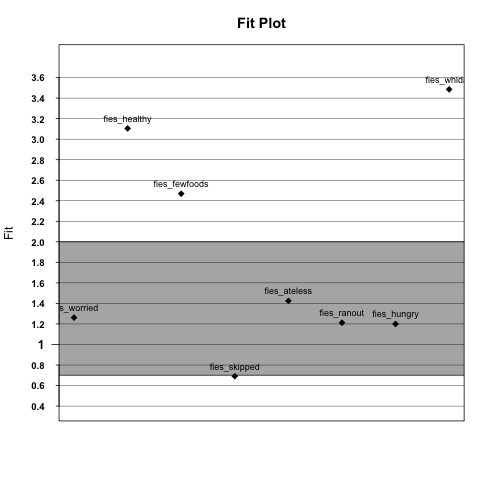

In [39]:
%%R
# # what about outfit?
outfit <- rr.nigeria$outfit


upper_bound <- rep(x = 2.0, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

* `fies_healthy`, `fies_fewfoods` and `fies_whlday` items have outfit of >2.
* Outfit statistics have a similar interpretation to the infit statistics, but are sensitive to
the presence of even just a few cases with highly unexpected response patterns, and are therefore
useful to flag the presence of outliers

#### Fit statistics - Rasch Reliability 
Rasch reliability provides information about the discriminatory power of the overall scale,
measuring the proportion of variability in the data that is explained by the Rasch model. 

In [40]:
%%R
# Rasch reliability
rr.nigeria$reliab

[1] 0.7123989


* For an 8-item FIES scale, a Rasch reliability value above 0.7 is considered acceptable.

#### **Rasch Description**

Compute the main descriptive tables (number of affirmative responses to each item,weighted and unweighted distribution across raw scores etc), weighted and unweighted, for Rasch scale items and respondents.

In [41]:
%%R
# Fit Rasch descriptives
fit.descr = tab.weight(wt = wt.nigeria, XX = xx.nigeria)

# Weighted and unweighted percentage of Yes per item
yes_per_item <- cbind("Weighted perc. of Yes" = fit.descr$Perc.Yes.w)
write.csv(yes_per_item, "../data/fies_yes_per_item.csv")
yes_per_item

              Weighted perc. of Yes
fies_worried                   0.88
fies_healthy                   0.92
fies_fewfoods                  0.90
fies_skipped                   0.84
fies_ateless                   0.89
fies_ranout                    0.42
fies_hungry                    0.53
fies_whlday                    0.21


* From the weighted percentage of "YES" responses to each item, it it observed that the high infit item `fies_whlday` was affirmed lowest (21%) of respondents. This is understandable as it is the most severe item in the scale.

#### Fit statistics - Residual correlation matrix

A residual correlation between a pair of items is considered high if it is >|0.4|

corrplot 0.92 loaded


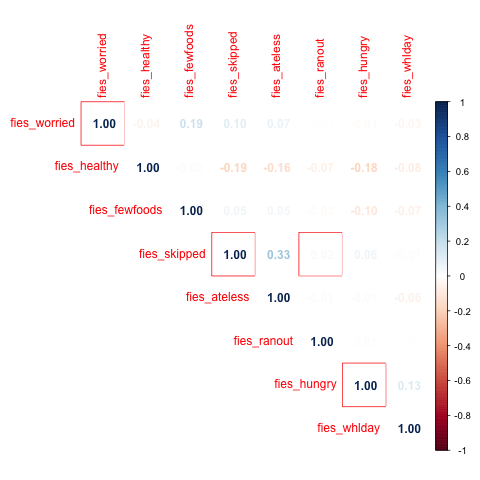

In [42]:
%%R
library(corrplot)
#  Residual correlation matrix 

# Set the threshold value for highlighting
threshold <- 0.4

cor_matrix <- rr.nigeria$res.corr

# Define colors for highlighting
highlight_color <- ifelse(abs(cor_matrix) > threshold, "red", "white")

# Plot the correlation matrix with highlighted values
corrplot(cor_matrix, method = "number", addgrid.col = highlight_color, type="upper")



**Observation**

* No pair of item have a correlation that is considered high (>0.4)
* Each item is seems to capture a different aspect of food insecurity, there are no redundant questions that would tend to weaken the ability to measure food insecurity accurately.

* One of the Rasch model assumptions is that all items discriminate equally, which
means that, ideally, all infit statistics would be 1.0. Infit values in the range of 0.7-1.3 are generally considered to meet the model assumption of equal discrimination to an acceptable degree. **Infit statistics in the range 1.3 to 1.5** identify items that can still be used for measurement, but attention to possible improvement of such item may be worthwhile.

**Impact**

* The misfit does not justify omitting `fies_healthy` item from the scale.

### 3. Calculation of Prevalence of Food Insecurity 

We will use output of the Rasch model, along with information about the distribution of the sample population across raw scores, to calculate estimates/probability of the prevalence of food insecurity that can be compared across countries (or across any application of the FIES).

**FAO** has developed an [**Excel Template**]() to facilitate the calculation of comparable food insecurity prevalence estimates. 

<center>   
    <p></p>
<img src="../assets/prevalence_threshold_excel.png" width="500" />
 <figcaption style="font-size: 10px; font-style: italic;">Fig. 3: Threshold and Prevalence of FI in Nigeria integrated household sixth-round holdhold survey in Nigeria. created using the FOA Excel template.</figcaption>
<p></p>
</center>

<center>   
    <p></p>
<img src="../assets/prevalence_threshold_excel2.png" width="500" />
 <figcaption style="font-size: 10px; font-style: italic;">Fig. 4: Item parameters of the 8 FIES items (FAO global scale 2014-2016) in Nigeria integrated household sixth-round holdhold survey in Nigeria. created using the FOA Excel template.</figcaption>
<p></p>
</center>




#### Adjusted thresholds

With the global standard item severities now adjusted to the country metric, we see our two standard thresholds are at the
adjusted severity level of ATELESS (-0.31179) and WHLDAY (4.6952)

**ATELESS `fies_ateless`** defines the boundary between
food security and moderate food insecurity.

**WHLDAY `fies_whlday`** defines the boundary between
moderate and severe food insecurity.

#### Probabilistic assignment

With the classes of food insecurity defined by the adjusted thresholds, prevalence rates can now be calculated. This begins with the probabilistic assignment of respondents to food insecurity classes, which means assigning each respondent a probability of falling into a certain class, i.e. that their true severity level is above or below the threshold, given their raw score.

In [46]:
%%R
#Probabilistic assignment -------------------------------------
# Pre-defined thresholds on the latent trait
# sthresh contains two possible thresholds on the latent trait
# to be used only within the same country 

sthresh = c(-0.7806, 4.6952)
pp.country1 = prob.assign(rr.nigeria, sthres = sthresh)$sprob
# Probability of being beyond -0.7806 on the latent trait in country 1 
print(pp.country1[1]*100)
# Probability of being beyond 4.6952 on the latent trait in country 1 
print(pp.country1[2]*100)

[1] 82.38703
[1] 16.68602


## Summary
* The validation test shows that `fies_healthy` did not perform well based on the infit statistic greater outside the acceptable range. We explored dropping the item below.
* The rasch model reliability 0.7123989
* From the number of "yes" responses to each item, it it observed that the high infit item `fies_whlday` was only affirmed by 21.0% of respondents. This is understandable as it is the most severe item in the scale.
* We use `fies_ateless` and `fies_whlday` as the thresholds between mildly and moderately food insecure, and between moderately and severely food insecure, respectively;
* Two standard thresholds are at the adjusted severity level of `fies_ateless` (-0.31179) and `fies_whlday` (4.6952)

**Overall Prevalence of FI according to sixth-round household survey in Nigeria**

* The resulting proportion of the sample population experiencing **moderate or severe FI** (FImod+sev) is 82.38%. The proportion of the population experiencing **severe FI** (FIsev) is 16.68 %.

**Impact**

* Download file containing the probability of moderate-or-severe or severe food insecurity for a respondent with each of the nine possible raw scores


In [ ]:
# TODO
# * Percentage of moderate or severe RFI and Severe RFI by state. **Do a map**
# * Relationship of FIES with shock, gender and income.

## FIES Analysis with `fies_healthy` dropped
The validation test shows that `fies_healthy` did not perform well based on the infit statistic greater outside the acceptable range.
Lets re-run the analysis by omitting `fies_healthy` item.


In [ ]:
%%R
# Questionare data and weights
xx.ng_new <- subset(xx.nigeria, select = -fies_healthy)
wt.ng_new  <- fies.ng$weight_final

# # Fit weight rasch model
rr.ng_new  <- RM.w(xx.ng_new , wt.ng_new)

# Fit Rasch descriptives
fit.descr = tab.weight(wt = wt.ng_new, XX = xx.ng_new)

# # # Fit unweighted Rasch
rr.ng_new.nw <- RM.w(xx.ng_new )

item_fit_stats <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.ng_new$b,              # Item severity estimate
    "Item Error" = rr.ng_new$se.b,          # Item standard error
    "Infit" = rr.ng_new$infit,                  # Infit
    "Std error Infit" = rr.ng_new$se.infit,     # standard error infit
    "Outfit" = rr.ng_new$outfit
  ),
  var = "Item"
)

resp_fit_stats <- tibble::rownames_to_column(
  data.frame(
    "Respondent Severity" = rr.ng_new$a,              # Item severity estimate
    "Respondent Error" = rr.ng_new$se.a,          # Item standard error
    "Wtd_N" = rr.ng_new$wt.rs
  ),
  var = "Item"
)



# # what about infit?
infit <- rr.ng_new$infit


upper_bound <- rep(x = 1.3, times = 7)
lower_bound <- rep(x = .70, times = 7) 

infit_plot <- fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.ng_new))

# What about the outfit
outfit <- rr.ng_new$outfit


upper_bound <- rep(x = 2.0, times =7) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 7) 

outfit_plot<-fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.ng_new))
print(outfit_plot)

#Save to csv
# Comma as separator and dot as decimal separator
# write.csv(item_fit_stats, "../data/fies_item_statistics.csv")

print(sprintf("The model reliability is %f", rr.ng_new$reliab))

print(sprintf("---------Item statistics --------------"))
print(item_fit_stats)

print(sprintf("---------Respondent/Raw score statistics --------------"))
print(resp_fit_stats)

print(sprintf("---------Weighted Percentage --------------"))
print(cbind("Weighted perc. of Yes" = fit.descr$Perc.Yes.w,
"Unweighted perc. of Yes" = fit.descr$Perc.Yes))